<a href="https://colab.research.google.com/github/Divak-ar/lung_cancer/blob/master/LungsModelSelection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install joblib scikit-learn matplotlib seaborn pandas numpy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from google.colab import files
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# Set style for plots
plt.style.use('ggplot')
sns.set_palette("Set2")

# Create directory for model storage
if not os.path.exists('models'):
    os.makedirs('models')

# Upload dataset
print("Please upload the 'survey lung cancer.csv' file")
uploaded = files.upload()  # This will prompt you to upload the CSV file

# Load the data
lung_data = pd.read_csv("survey lung cancer.csv")

# Display first few rows
print("\nFirst 5 rows of the dataset:")
lung_data.head()


Please upload the 'survey lung cancer.csv' file


Saving survey lung cancer.csv to survey lung cancer.csv

First 5 rows of the dataset:


,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,M,69,1,2,2,1,1,2,1,2,2,2,2,2,2,YES
1,M,74,2,1,1,1,2,2,2,1,1,1,2,2,2,YES
2,F,59,1,1,1,2,1,2,1,2,1,2,2,1,2,NO
3,M,63,2,2,2,1,1,1,1,1,2,1,1,2,2,NO
4,F,63,1,2,1,1,1,1,1,2,1,2,2,1,1,NO


In [ ]:
print("\nEncoding ...")
lung_data.GENDER = lung_data.GENDER.map({"M":1,"F":2})
lung_data.LUNG_CANCER = lung_data.LUNG_CANCER.map({"YES":1,"NO":2})


Encoding ...



Class distribution:


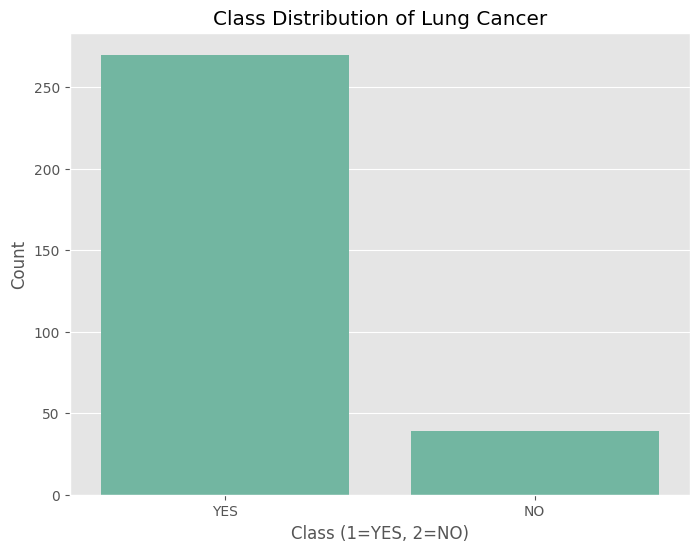

YES: 270 samples
NO: 39 samples


In [ ]:
print("\nClass distribution:")
plt.figure(figsize=(8, 6))
class_counts = lung_data['LUNG_CANCER'].value_counts()
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Class Distribution of Lung Cancer')
plt.xlabel('Class (1=YES, 2=NO)')
plt.ylabel('Count')
plt.xticks([0, 1], ['YES', 'NO'])
plt.show()
print(f"YES: {class_counts[1]} samples")
print(f"NO: {class_counts[2]} samples")

In [ ]:
# Split feature and target
X = lung_data.iloc[:,0:-1]
y = lung_data.iloc[:,-1]

# Save feature names for later use
feature_names = X.columns.tolist()
with open('feature_names.txt', 'w') as f:
    f.write(','.join(feature_names))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)

print("\nSplit data:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")


Split data:
Training set: 206 samples
Testing set: 103 samples


In [ ]:
# Create a function for model evaluation
def evaluate_model(model, X_test, y_test, model_name):
    """Evaluate model performance and return metrics"""
    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Get class-specific metrics
    precision_classes = precision_score(y_test, y_pred, average=None)
    recall_classes = recall_score(y_test, y_pred, average=None)
    f1_classes = f1_score(y_test, y_pred, average=None)

    # Print evaluation results
    print(f"\n{model_name} - Performance Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Calculate ROC curve and AUC (if probability prediction is supported)
    try:
        y_prob = model.predict_proba(X_test)
        # For the positive class (YES/1)
        y_prob_positive = y_prob[:, 0]

        # Convert y_test to binary (0 for negative, 1 for positive)
        y_test_binary = (y_test == 1).astype(int)

        fpr, tpr, _ = roc_curve(y_test_binary, y_prob_positive)
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {model_name}')
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)
        plt.show()
    except:
        print("ROC curve could not be generated for this model.")
        roc_auc = None

    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm,
        'precision_classes': precision_classes,
        'recall_classes': recall_classes,
        'f1_classes': f1_classes,
        'auc': roc_auc,
        'model': model  # Store the model object itself
    }



Training Logistic Regression...

Logistic Regression - Performance Metrics:
Accuracy: 0.9709
Precision: 0.9794
Recall: 0.9896
F1-score: 0.9845


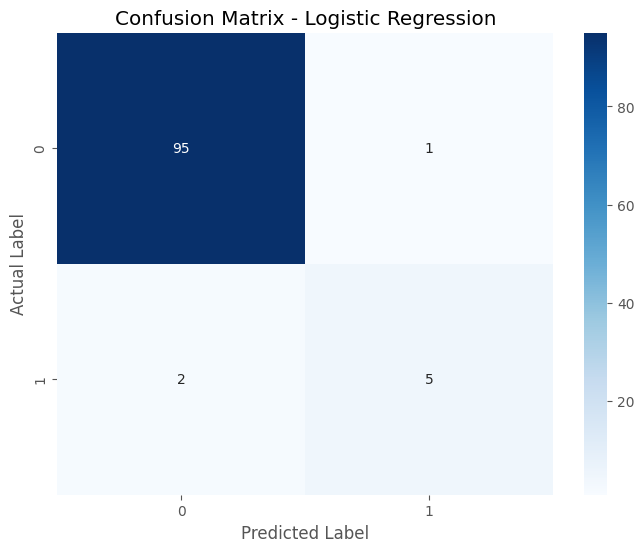

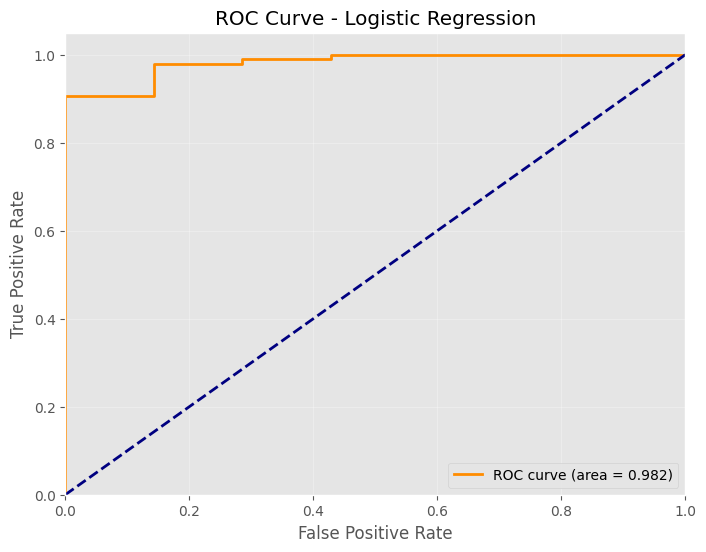


Training K-Nearest Neighbors...

K-Nearest Neighbors - Performance Metrics:
Accuracy: 0.9320
Precision: 0.9495
Recall: 0.9792
F1-score: 0.9641


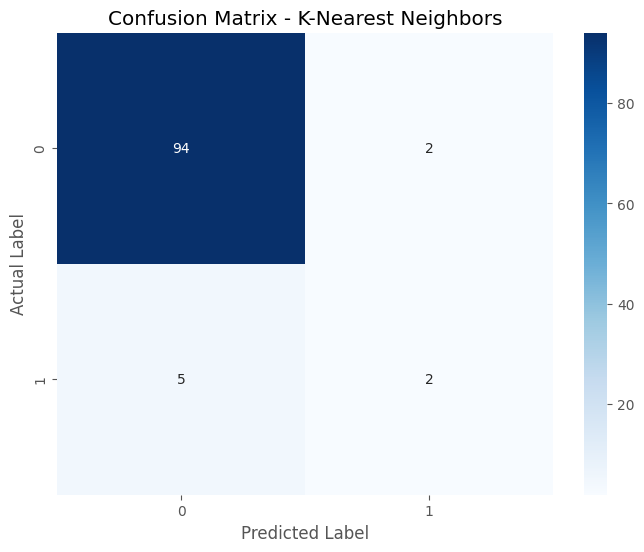

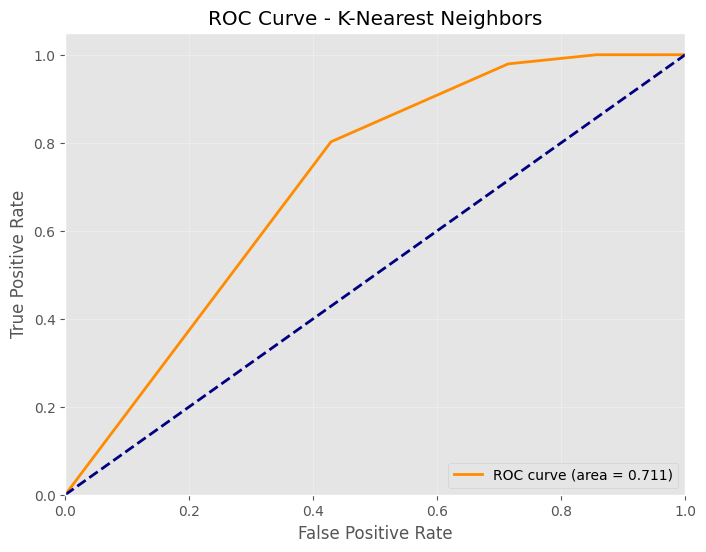


Training Decision Tree...

Decision Tree - Performance Metrics:
Accuracy: 0.9709
Precision: 0.9794
Recall: 0.9896
F1-score: 0.9845


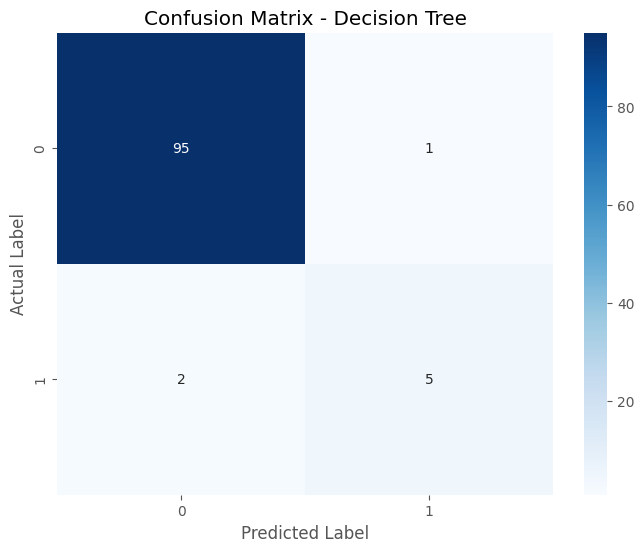

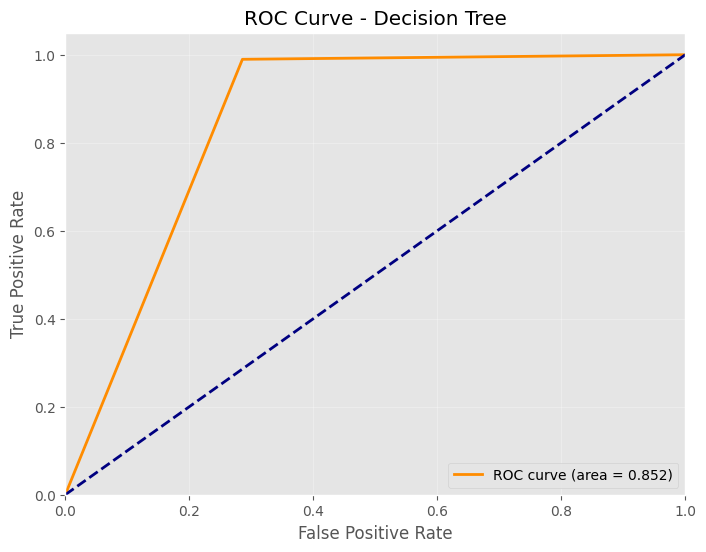


Training Random Forest...

Random Forest - Performance Metrics:
Accuracy: 0.9709
Precision: 0.9794
Recall: 0.9896
F1-score: 0.9845


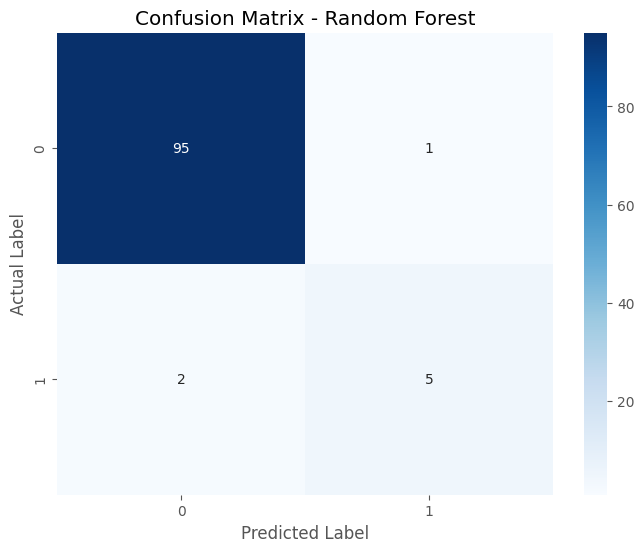

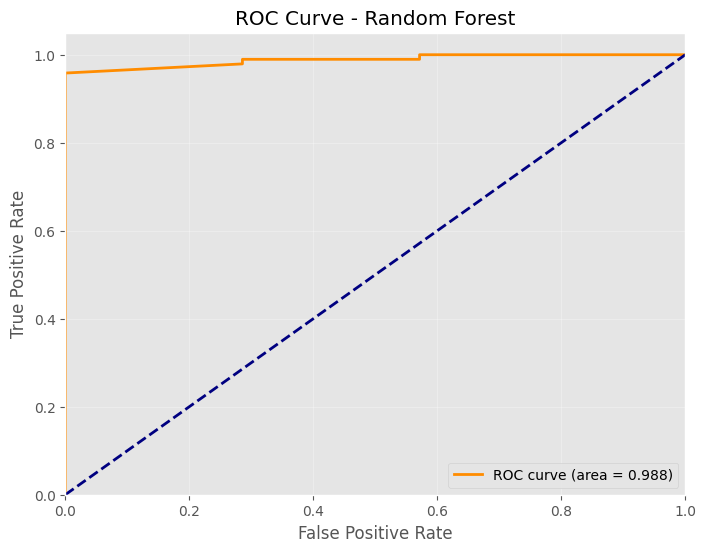


Training Support Vector Machine...

Support Vector Machine - Performance Metrics:
Accuracy: 0.9320
Precision: 0.9320
Recall: 1.0000
F1-score: 0.9648


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


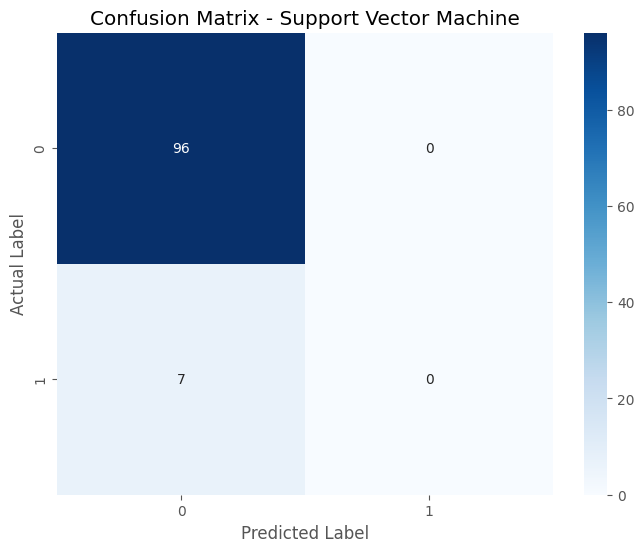

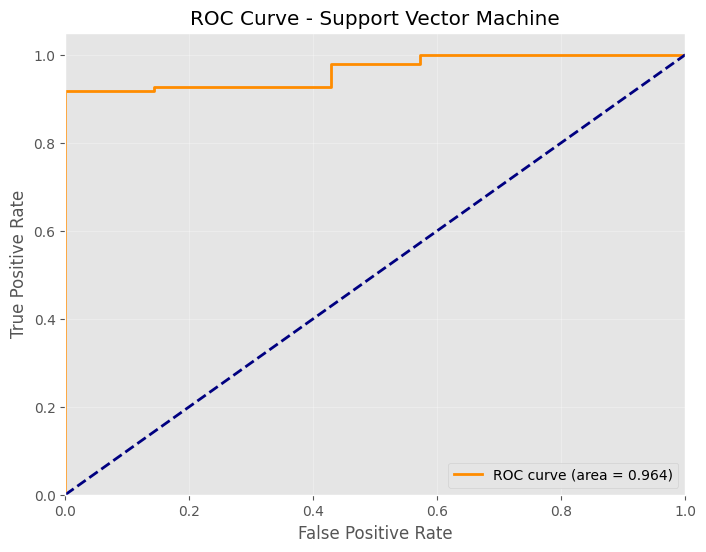


Training Naive Bayes...

Naive Bayes - Performance Metrics:
Accuracy: 0.9515
Precision: 0.9691
Recall: 0.9792
F1-score: 0.9741


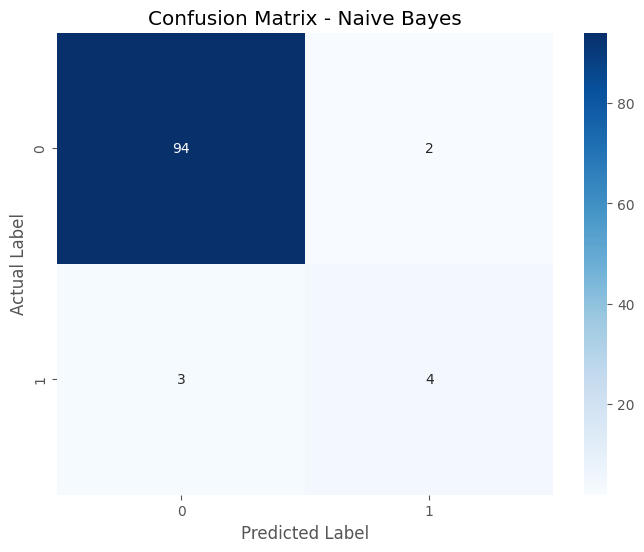

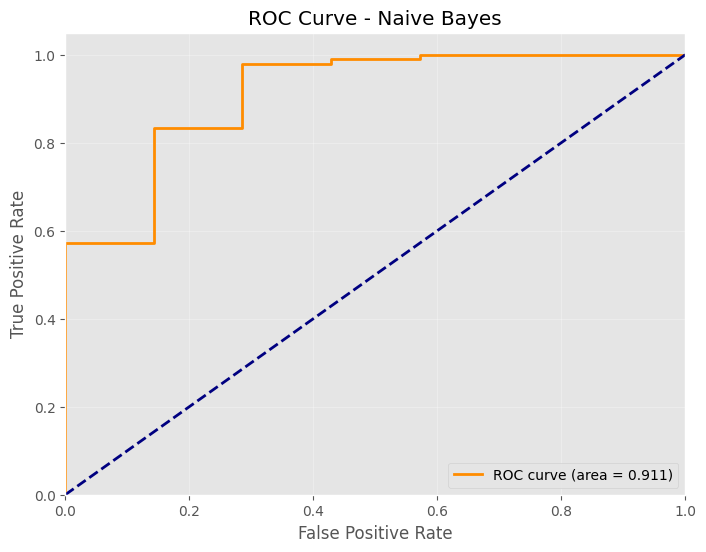


Model Comparison Summary:


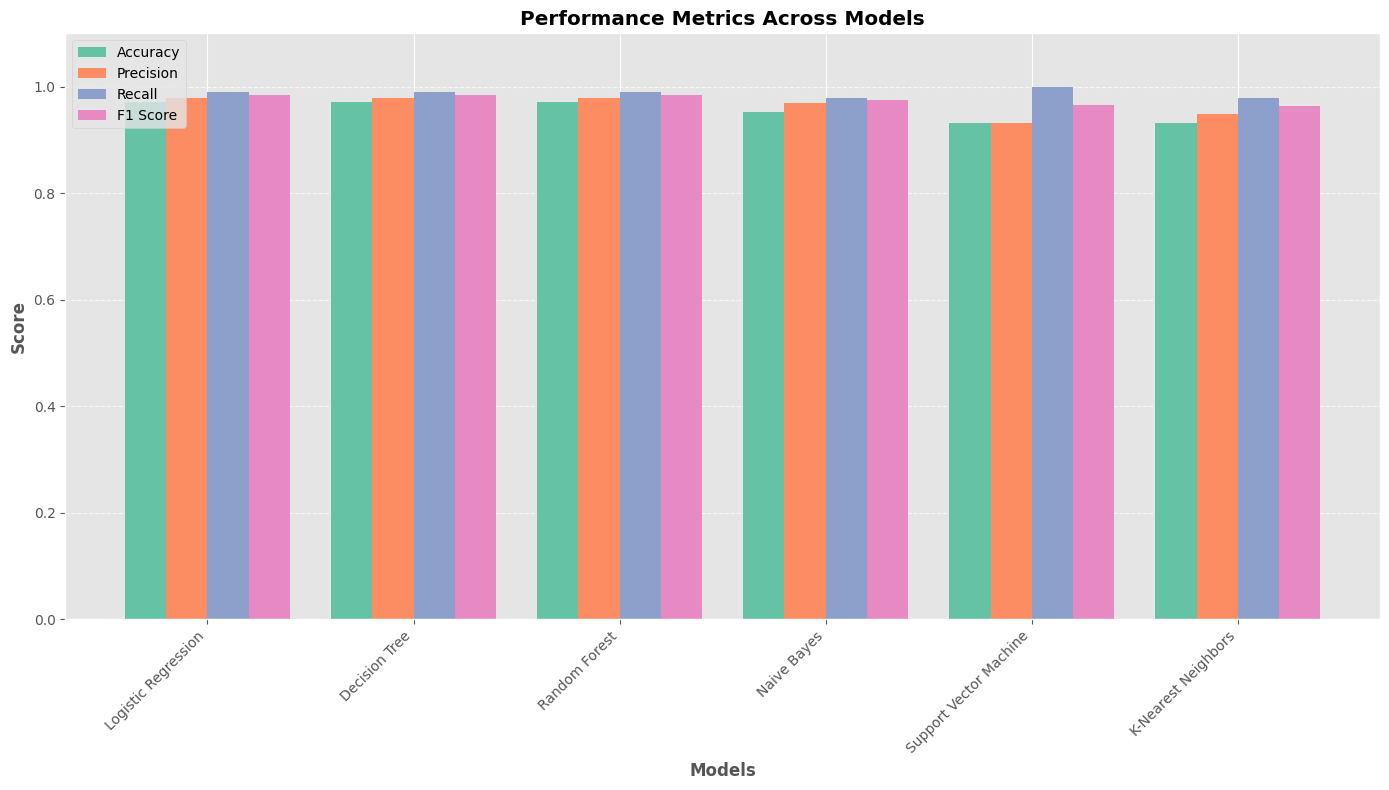


Available models for export:
1. Logistic Regression
2. K-Nearest Neighbors
3. Decision Tree
4. Random Forest
5. Support Vector Machine
6. Naive Bayes

Default model: Logistic Regression
Enter model number to export (or press Enter for default Logistic Regression): 6


In [ ]:
# Initialize models dictionary to store all results
models_dict = {}
results = []

# 1. Logistic Regression
print("\n" + "="*50)
print("Training Logistic Regression...")
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
lr_results = evaluate_model(lr_model, X_test, y_test, "Logistic Regression")
results.append(lr_results)
models_dict['Logistic Regression'] = lr_model

# 2. K-Nearest Neighbors
print("\n" + "="*50)
print("Training K-Nearest Neighbors...")
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train, y_train)
knn_results = evaluate_model(knn_model, X_test, y_test, "K-Nearest Neighbors")
results.append(knn_results)
models_dict['K-Nearest Neighbors'] = knn_model

# 3. Decision Tree
print("\n" + "="*50)
print("Training Decision Tree...")
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
dt_results = evaluate_model(dt_model, X_test, y_test, "Decision Tree")
results.append(dt_results)
models_dict['Decision Tree'] = dt_model

# 4. Random Forest
print("\n" + "="*50)
print("Training Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_results = evaluate_model(rf_model, X_test, y_test, "Random Forest")
results.append(rf_results)
models_dict['Random Forest'] = rf_model

# 5. Support Vector Machine
print("\n" + "="*50)
print("Training Support Vector Machine...")
svm_model = SVC(probability=True, random_state=42)
svm_model.fit(X_train, y_train)
svm_results = evaluate_model(svm_model, X_test, y_test, "Support Vector Machine")
results.append(svm_results)
models_dict['Support Vector Machine'] = svm_model

# 6. Naive Bayes
print("\n" + "="*50)
print("Training Naive Bayes...")
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
nb_results = evaluate_model(nb_model, X_test, y_test, "Naive Bayes")
results.append(nb_results)
models_dict['Naive Bayes'] = nb_model

# Create a DataFrame with results for comparison
print("\n" + "="*50)
print("Model Comparison Summary:")
metrics_df = pd.DataFrame({
    'Model': [result['model_name'] for result in results],
    'Accuracy': [result['accuracy'] for result in results],
    'Precision': [result['precision'] for result in results],
    'Recall': [result['recall'] for result in results],
    'F1 Score': [result['f1_score'] for result in results],
    'AUC': [result['auc'] for result in results]
})

# Sort by F1 score descending
metrics_df = metrics_df.sort_values(by='F1 Score', ascending=False)
metrics_df

# Visualize the performance metrics
plt.figure(figsize=(14, 8))
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
bar_width = 0.2
x = np.arange(len(metrics_df['Model']))

for i, metric in enumerate(metrics_to_plot):
    plt.bar(x + (i - 1.5) * bar_width, metrics_df[metric], width=bar_width, label=metric)

plt.xlabel('Models', fontweight='bold')
plt.ylabel('Score', fontweight='bold')
plt.title('Performance Metrics Across Models', fontweight='bold')
plt.xticks(x, metrics_df['Model'], rotation=45, ha='right')
plt.legend(loc='upper left')
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# User Input for Model Selection
print("\n" + "="*50)
print("Available models for export:")
for i, model_name in enumerate(models_dict.keys(), 1):
    print(f"{i}. {model_name}")

# Default to Logistic Regression if no selection is made
default_model = 'Logistic Regression'
print(f"\nDefault model: {default_model}")

# User can choose model
while True:
    try:
        user_input = input(f"Enter model number to export (or press Enter for default {default_model}): ")

        if user_input.strip() == '':
            selected_model_name = default_model
            break

        model_index = int(user_input) - 1
        selected_model_name = list(models_dict.keys())[model_index]
        break
    except (ValueError, IndexError):
        print("Invalid selection. Please try again.")

In [ ]:
# Get the selected model
selected_model = models_dict[selected_model_name]
print(f"\nExporting {selected_model_name} model...")

# Export the selected model
model_path = 'lung_cancer_model.pkl'
joblib.dump(selected_model, model_path)
print(f"Model saved as: {model_path}")

# Also save feature names
with open('feature_names.txt', 'w') as f:
    f.write(','.join(feature_names))
print(f"Feature names saved to: feature_names.txt")

# Download the exported files
print("\nDownloading model and feature names files...")
files.download(model_path)
files.download('feature_names.txt')

# Feature importance for the selected model
print("\n" + "="*50)
print(f"Feature Analysis for {selected_model_name}:")

# If the selected model is Random Forest or Decision Tree, analyze feature importance
if selected_model_name in ['Random Forest', 'Decision Tree']:
    # Get feature importance
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': selected_model.feature_importances_
    })
    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

    # Plot feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance)
    plt.title(f'Feature Importance - {selected_model_name}')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

    # Display feature importance
    print("\nFeature Importance:")
    feature_importance
elif selected_model_name == 'Logistic Regression':
    # Get coefficients
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': selected_model.coef_[0]
    })
    feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)

    # Plot coefficients
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Coefficient', y='Feature', data=feature_importance)
    plt.title('Feature Coefficients - Logistic Regression')
    plt.xlabel('Coefficient')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

    # Display coefficients
    print("\nLogistic Regression Coefficients:")
    feature_importance
else:
    print(f"Feature importance visualization not available for {selected_model_name}.")



Exporting Naive Bayes model...
Model saved as: lung_cancer_model.pkl
Feature names saved to: feature_names.txt



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Feature Analysis for Naive Bayes:
Feature importance visualization not available for Naive Bayes.
